# Paper experiments

### 1. **Table 2 and 3**: Accuracy and training time tables comparing MICAT performances with competitors 

"MICAT" framework is refered as "GAP" in the code, and 'Naive-CAT' as Adam. The first cell set the configuration. **Hyperparameters** must be adapted as indicated, depending on the combination of (Dataset, CDM, Competitor), according to the values contained in file : **'MICAT/experiments/data/CAT_hyperparameters.csv'**, **'MICAT/experiments/data/CDM_hyperparameters.csv'**

### 1.0. Configuration : Choose your combination (Dataset, CDM, Adaptation method), and set the corresponding parameters

In [ ]:
import micat
config = micat.utils.generate_eval_config(
    #### Change the following values: ####

    ### Dataset name :
    dataset_name="assist0910",  # ['assist0910', 'math2', 'algebra']
    n_query=16, #{'assist0910':16, 'math2':16, 'algebra':25}

    ### CDM: 
    CDM = 'impact', # ['impact','ncdm']
    lambda_=7.380681029927064e-05,
    learning_rate = 0.001,

    ### Competitor:     
    meta_trainer='GAP', #['Adam', 'Approx_GAP','MAML','GAP', 'BETA-CD']
    num_inner_users_epochs=3,
    inner_user_lr= 0.0007838402204978467,
    meta_lr=0.05,

    #### Fixed hyperpameters ####
    load_params=True,
    
    save_params=False,
    esc = 'error',
    batch_size = 512,
    valid_batch_size = 10000,
    num_epochs=100,
    eval_freq = 1,
    patience = 20,
    pred_metrics = ["mi_acc","rmse","mae","mi_prec","mi_rec","mi_f_b","mi_auc","ma_prec","ma_rec","ma_f_b"],
    profile_metrics = ['meta_doa','pc-er','rm'],
    valid_metric= 'rmse',
)

#### Extra method-specific hyperparameters : 

## BETA-CD
config['kl_weight'] =0.0005

## MICAT (GAP)
config['learning_users_emb_lr'] = 0.0001

### 1.1. Launch script (to run only)

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["PYTHONHASHSEED"] = "0"
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"

import micat
micat.utils.set_seed(0)
from micat.dataset import preprocessing_utilities as pu

import logging
import gc
import json
import torch
import pandas as pd
import argparse
import time 

print("PID", os.getpid(), "sees CUDA_VISIBLE_DEVICES =", os.environ.get("CUDA_VISIBLE_DEVICES"))
if os.environ.get("CUDA_VISIBLE_DEVICES") is not None:
    print("→ torch.device is", torch.cuda.current_device(), torch.cuda.get_device_name(0))
    
logging.info(f'#### config : {config} ####')

concept_map = json.load(open(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_concept_map.json', 'r'
))
concept_map = {int(k): [int(x) for x in v] for k, v in concept_map.items()}

metadata = json.load(open(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_metadata.json', 'r'
))

nb_modalities = torch.load(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_nb_modalities.pkl',
    weights_only=True
)

for i_fold in range(5):
    train_df = pd.read_csv(
        f'../datasets/2-preprocessed_data/{config["dataset_name"]}_train_{i_fold}.csv',
        encoding='utf-8',
        dtype={'student_id': int, 'item_id': int, "correct": float, "dimension_id": int}
    )
    valid_df = pd.read_csv(
        f'../datasets/2-preprocessed_data/{config["dataset_name"]}_valid_{i_fold}.csv',
        encoding='utf-8',
        dtype={'student_id': int, 'item_id': int, "correct": float, "dimension_id": int}
    )
    test_df = pd.read_csv(
        f'../datasets/2-preprocessed_data/{config["dataset_name"]}_test_{i_fold}.csv',
        encoding='utf-8',
        dtype={'student_id': int, 'item_id': int, "correct": float, "dimension_id": int}
    )

    train_data = micat.dataset.CATDataset(train_df, concept_map, metadata, config, nb_modalities)
    valid_data = micat.dataset.EvalDataset(valid_df, concept_map, metadata, config, nb_modalities)
    test_data  = micat.dataset.EvalDataset(test_df,  concept_map, metadata, config, nb_modalities)

    S = micat.selectionStrategy.Random(train_data.metadata, **config)
    S.init_models(train_data, valid_data)

    # — Training time measurement
    logging.info("⏳ Training started...")
    t_start = time.time()
    S.train(train_data, valid_data)
    t_end = time.time()
    logging.info(f"✅ Training completed in {t_end - t_start:.2f} seconds.")

    S.reset_rng()
    d = S.evaluate_test(test_data, train_data, valid_data)
    logging.info(f"Fold {config['i_fold']}; results: {d}")

    del S
    gc.collect()
    torch.cuda.empty_cache()

In [6]:
import os
os.chdir('/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/experiments/notebook_example')
current_dir = os.getcwd()
print(current_dir)


/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/experiments/notebook_example


### 2. **Figure 2**: Critical Difference Diagram ranking MICAT performances and interpretability with competitors

Generate latex of the diagram in 'MICAT/experiments/data/critical_diff.tex'

### (to run only)

In [15]:
#!/usr/bin/env python3
import numpy as np
import json
import glob
import re
import os
import math
import ast
import warnings
warnings.filterwarnings('ignore')

algorithms = ["Adam", "MAML", "Approx_GAP", "Beta_cd", "MICAT"]
datasets = ["algebra", "assist0910", "math2"]
metrics = ["mi_acc","rmse","mae","mi_prec","mi_rec","mi_f_b","mi_auc","ma_prec","ma_rec","ma_f_b","meta_doa","pc-er","rm"]

pattern = re.compile(
    r"^CAT_launch_"
    r"(?P<dataset>.+?)_"
    r"(?P<subalgo>.+?)_"
    r"(?P<algorithm>.+?)_"
    r"\d+_all_results\.json$"
)

output_dir = "cd_plots"
os.makedirs(output_dir, exist_ok=True)

def is_finite(x):
    try:
        return math.isfinite(float(x))
    except Exception:
        return False

def parse_dict_from_text(txt):
    m = re.search(r"[Rr]esults?:\s*\(\s*({.*?})\s*,\s*({.*?})\s*\)", txt, re.DOTALL)
    if not m:
        return {}, {}
    def _eval(s):
        s = s.replace("np.float64", "").replace("np.int64", "").replace("nan", "None")
        try:
            return ast.literal_eval(s)
        except Exception:
            return {}
    d1 = _eval(m.group(1))
    d2 = _eval(m.group(2))
    merged = {}
    for d in (d1, d2):
        for k, v in (d or {}).items():
            if is_finite(v):
                merged[k] = float(v)
    return merged

def load_cdm_basis(dataset, subalgo):
    pattern_basis = f"../scripts/logs/CAT_launch_{dataset}_{subalgo}_CDM_basis_*_*.out"
    files_basis = glob.glob(pattern_basis)
    if not files_basis:
        print(f"[WARN] No CDM_basis found for {dataset}/{subalgo}")
        return {}, {}
    per_fold = {}
    per_metric = {}
    for fb in files_basis:
        m = re.search(r"_(\d+)\.out$", fb)
        if not m:
            continue
        fold = int(m.group(1))
        with open(fb, "r") as f:
            txt = f.read()
        merged = parse_dict_from_text(txt)
        per_fold[fold] = merged
        for k, v in merged.items():
            per_metric.setdefault(k, []).append(v)
    mean_metrics = {k: np.mean(v) for k, v in per_metric.items() if v}
    return per_fold, mean_metrics

results = {m: {a: [] for a in algorithms} for m in metrics}
files = glob.glob("../scripts/logs/CAT_launch_*_IMPACT_*_all_results.json") + \
        glob.glob("../scripts/logs/CAT_launch_*_NCDM_*_all_results.json")
print(f"[INFO] Found {len(files)} candidate result files.")

for file in files:
    m = pattern.match(os.path.basename(file))
    if not m:
        print(f"[WARN] Filename does not match expected pattern: {file}")
        continue
    ds, subalgo, algo = m["dataset"], m["subalgo"], m["algorithm"]
    if ds not in datasets or algo not in algorithms:
        continue
    if ds == "algebra" and subalgo == "NCDM":
        continue

    basis_per_fold, basis_mean = load_cdm_basis(ds, subalgo)
    if not basis_per_fold:
        continue

    try:
        with open(file, "r") as f:
            folds = json.load(f)

        for fold_idx, fold_data in folds.items():
            fold_idx = int(fold_idx)
            value_acc = {metric: 0.0 for metric in metrics}

            # Each fold_data has {0: predictive, 1: interpretability}
            for pred_meta_idx, step_dict in fold_data.items():
                for step, metric_dict in step_dict.items():
                    for metric in metrics:
                        value = metric_dict.get(metric)
                        if value is None or np.isnan(value):
                            continue
                        # Apply CDM basis correction if available
                        if (
                            metric in basis_mean
                            and fold_idx in basis_per_fold
                            and metric in basis_per_fold[fold_idx]
                        ):
                            base_adj = basis_mean[metric] - basis_per_fold[fold_idx][metric]
                            value = float(value) + base_adj
                        value_acc[metric] += value

            for metric in metrics:
                results[metric][algo].append(value_acc[metric])

    except Exception as e:
        print(f"[ERROR] Failed to process {file}: {repr(e)}")



from critdd import Diagrams # Diagrams is the 2D version of Diagram
import numpy as np


# construct a sequence of CD diagrams
treatment_names = ["Naïve", "MAML", "Approx-GAP", "BETA-CD", "MICAT"]
metrics = ["mi_acc","mi_prec","mi_rec","mi_f_b","mi_auc",'meta_doa']
diagram_names = ["Accuracy","Precision","Recall","F1","AUC",'Meta Doa']
Xs = [] # collect an (n,k)-shaped matrix for each diagram
for n in metrics:
    Xs.append(np.array([results[n][algo] for algo in algorithms]).T)

two_dimensional_diagram = Diagrams(
    np.stack(Xs),
    diagram_names = diagram_names,
    treatment_names = treatment_names,
    maximize_outcome = True
)

two_dimensional_diagram.to_file(
    "../data/critical_diff.tex",
    alpha = .05,
    adjustment = "holm",
    reverse_x = True,
    axis_options = {"title": ""},
)
print("Critical difference diagram saved to ../data/critical_diff.tex")

[INFO] Found 31 candidate result files.
Critical difference diagram saved to ../data/critical_diff.tex


### 3. **Figure 3**: Visualization of student proficiency estimate during Meta-testing procedure with MICAT and CD-BPR

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["PYTHONHASHSEED"] = "0"
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"

import micat
import logging
import gc
import json
import torch
import pandas as pd
from micat.dataset import preprocessing_utilities as pu
import argparse
import warnings
import time  # ← Added to measure time

dataset_name = "math2"
cdm="impact"
i_fold=3

gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

config = micat.utils.generate_eval_config(
    CDM=cdm,
    dataset_name=dataset_name,
    i_fold = i_fold,
    load_params=True,
    save_params=False,
    esc = 'error',
    learning_rate = 0.001,
    batch_size = 512,
    valid_batch_size = 10000,
    num_epochs=100,
    eval_freq = 1,
    patience = 20,
    device = device,
    pred_metrics = ["mi_acc","rmse","mae","mi_prec","mi_rec","mi_f_b","mi_auc","ma_prec","ma_rec","ma_f_b"],
    profile_metrics = ['meta_doa','pc-er','rm'],
    meta_trainer='GAP',
    valid_metric= 'rmse',
    n_query=16,
    num_inner_users_epochs=3,
    lambda_=2.6180638633142202e-05,
    inner_user_lr=0.0030952659036283066,
    meta_lr=0.01
)
config['learning_users_emb_lr'] = 0.001
logging.info(f'#### config : {config} ####')

concept_map = json.load(open(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_concept_map.json', 'r'
))
concept_map = {int(k): [int(x) for x in v] for k, v in concept_map.items()}

metadata = json.load(open(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_metadata.json', 'r'
))

nb_modalities = torch.load(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_nb_modalities.pkl',
    weights_only=True
)

train_df = pd.read_csv(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_train_{i_fold}.csv',
    encoding='utf-8',
    dtype={'student_id': int, 'item_id': int, "correct": float, "dimension_id": int}
)
valid_df = pd.read_csv(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_valid_{i_fold}.csv',
    encoding='utf-8',
    dtype={'student_id': int, 'item_id': int, "correct": float, "dimension_id": int}
)
test_df = pd.read_csv(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_test_{i_fold}.csv',
    encoding='utf-8',
    dtype={'student_id': int, 'item_id': int, "correct": float, "dimension_id": int}
)

train_data = micat.dataset.CATDataset(train_df, concept_map, metadata, config, nb_modalities)
valid_data = micat.dataset.EvalDataset(valid_df, concept_map, metadata, config, nb_modalities)
test_data  = micat.dataset.EvalDataset(test_df,  concept_map, metadata, config, nb_modalities)

S = micat.selectionStrategy.Random(train_data.metadata, **config)
S.init_models(train_data, valid_data)

test_emb = torch.load(f'../data/evolving_emb_tensor_MICAT_{i_fold}.pt',weights_only=True).cpu()



In [4]:
train_emb = S.CDM.model.users_emb.weight#torch.load(f'../data/train_emb_tensor_MICAT_{i_fold}.pt',weights_only=False).weight.cpu()
q_ids=torch.load(f'../data/_sub_question_ids_MICAT_3.pt').cpu()
u_ids=torch.load(f'../data/_sub_user_ids_MICAT_3.pt').cpu()
l_ids=torch.load(f'../data/_sub_labels_MICAT_3.pt').cpu()
#c_ids=torch.load(f'../data/_sub_categories_MICAT_3.pt').cpu()

train_users_ids = torch.Tensor(list(train_data.users_id)).long()
train_emb = train_emb[train_users_ids]

In [4]:
t2_emb = test_emb[:,test_emb.var(dim=0)!=0].reshape(16,-1,16)

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w = v[test_data.df['dimension_id'] == 0]


Student 1600 : Category 2: 3/100, Category 13: 5/100
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        1, 1, 1, 2, 2])
tensor([ 3,  3,  3, 14, 14, 14,  4,  4,  4,  4,  9,  9,  9,  0,  0,  0, 10, 10,
        10, 10,  2,  2,  2,  2,  6,  6,  6, 15, 15, 15,  5,  5,  5,  5, 12, 12,
         8,  8,  8,  8, 17, 17, 17, 17, 17,  1,  1, 11, 11, 11, 11, 13, 13])


/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:216: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


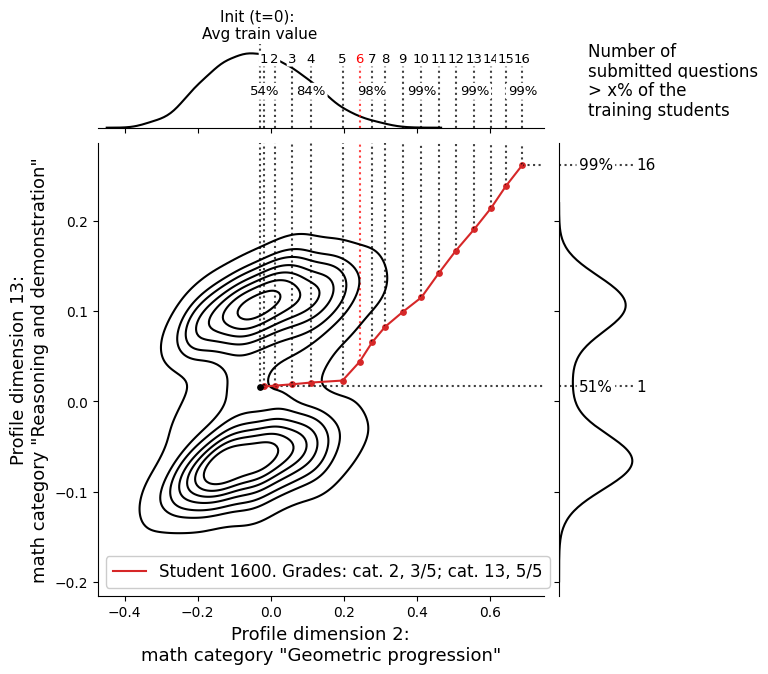

In [35]:
pu.plot_embedding_distribution(2,13,train_emb.detach().cpu().numpy(),test_emb, test_data=test_data, train_emb=train_emb, q_ids=q_ids, u_ids=u_ids,l_ids=l_ids)

/lustre/fsn1/projects/rech/enh/unv34ei/MICAT/micat/dataset/preprocessing_utilities.py:799: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


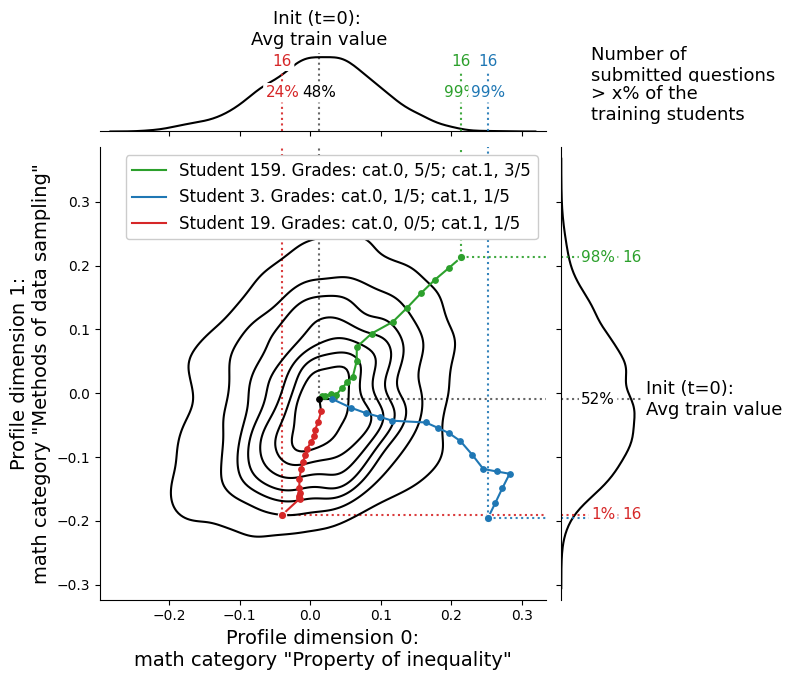

In [31]:
for i in range(1) : 
    pu.plot_embedding_distribution_comp(i,i+1,train_emb.detach().cpu().numpy(), test_emb, test_data=test_data,train_emb=train_emb)

### 4. **Figure 4**: Accuracy across ablation study variants of MICAT

Loaded methods: ['CDM_basis', 'MICAT', 'MICAT_CW', 'MICAT_CW_PREC', 'MICAT_INIT', 'MICAT_INIT_CW', 'MICAT_INIT_PREC', 'MICAT_PREC']


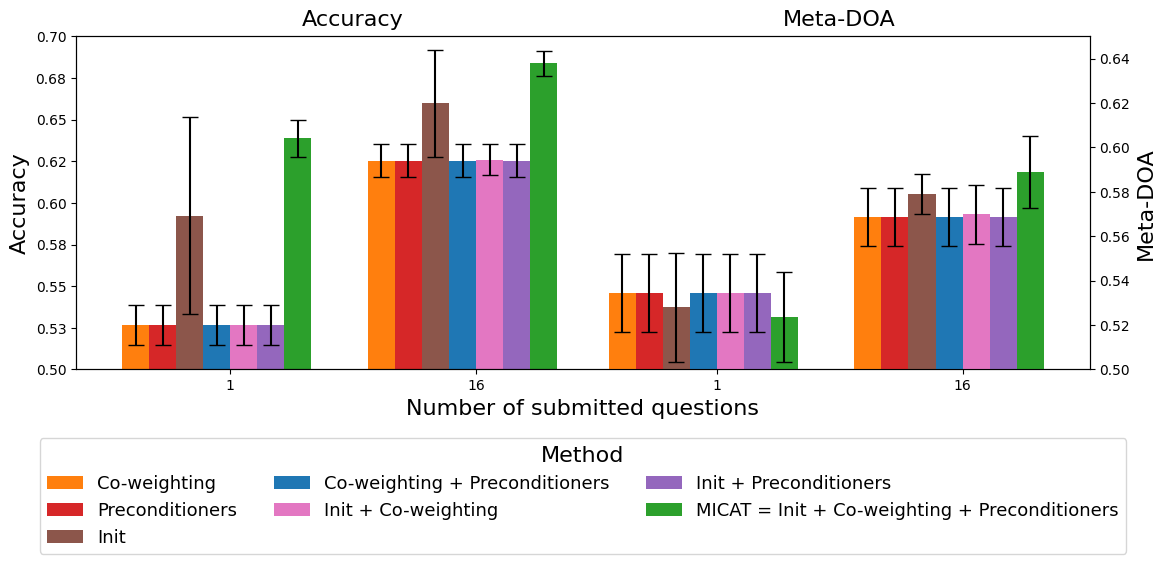

[SAVE] ../data/Ablation.png


In [6]:
# JUPYTER NOTEBOOK CELL
import glob
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# =========================
# User parameters (edit here)
# =========================
INPUT_DIR = "../scripts/result_ablation/"          # folder containing CAT_launch_*_IMPACT_*_all_results.json
OUTPUT_FILE = "../data/Ablation.png"
STEPS = [0, 15]                  # step indices to plot (0 -> 1 question, 15 -> 16 questions)
DPI = 300

# Preferred method ordering (will only plot those present)
PREFERRED_METHODS = [
    'MICAT_CW', 'MICAT_PREC', 'MICAT_INIT', 'MICAT_CW_PREC',
    'MICAT_INIT_CW', 'MICAT_INIT_PREC', 'MICAT'
]

# Colors & labels (fallback to method name if missing)
COLORS = {
    'MICAT_INIT': 'tab:brown',
    'MICAT_INIT_CW': 'tab:pink',
    'MICAT': 'tab:green',
    'MICAT_INIT_PREC': 'tab:purple',
    'MICAT_PREC': 'tab:red',
    'MICAT_CW': 'tab:orange',
    'MICAT_CW_PREC': 'tab:blue'
}
LABELS = {
    'MICAT_INIT': 'Init',
    'MICAT_INIT_CW': 'Init + Co-weighting',
    'MICAT': 'MICAT = Init + Co-weighting + Preconditioners',
    'MICAT_INIT_PREC': 'Init + Preconditioners',
    'MICAT_PREC': 'Preconditioners',
    'MICAT_CW': 'Co-weighting',
    'MICAT_CW_PREC': 'Co-weighting + Preconditioners'
}

# =========================
# Robust helpers
# =========================
def _as_int_key(k):
    try:
        return int(k)
    except Exception:
        return k

def _get_fold_blocks(fold_obj):
    """
    A fold typically looks like:
      { "0": {step-> {"mi_acc": ...}}, "1": {step-> {"meta_doa": ...}} }
    Return (block_metrics, block_meta) or ({}, {}) if not present.
    """
    if isinstance(fold_obj, dict):
        norm = { _as_int_key(k): v for k, v in fold_obj.items() }
        block_metrics = norm.get(0, {})
        block_meta    = norm.get(1, {})
        if not isinstance(block_metrics, dict): block_metrics = {}
        if not isinstance(block_meta, dict):    block_meta = {}
        return block_metrics, block_meta
    return {}, {}

def _extract_value(d, key, default=None):
    if not isinstance(d, dict):
        return default
    if key in d:
        return d[key]
    sk = str(key)
    if sk in d:
        return d[sk]
    return default

# =========================
# Load files
# =========================
method_pattern = re.compile(r'IMPACT_([A-Za-z0-9_]+)_\d+_all_results\.json')
pattern = os.path.join(INPUT_DIR, "CAT_launch_*_IMPACT_*_all_results.json")
files = glob.glob(pattern)

results = {}
for file in files:
    filename = os.path.basename(file)
    m = method_pattern.search(filename)
    if not m:
        print(f"[WARN] filename did not match expected pattern, skipping: {filename}")
        continue
    method = m.group(1)
    try:
        with open(file, "r") as f:
            data = json.load(f)
        if isinstance(data, dict):
            results[method] = data
        else:
            print(f"[WARN] Unexpected JSON root (not dict) in {filename}, skipping.")
    except Exception as e:
        print(f"[WARN] Failed to read {filename}: {e}")

if not results:
    print(f"[ERROR] No usable JSON files found in: {INPUT_DIR}")
else:
    print("Loaded methods:", sorted(results.keys()))

# =========================
# Select methods to plot
# =========================
methods = [m for m in PREFERRED_METHODS if m in results]
if not methods:
    methods = sorted(results.keys())

# =========================
# Aggregate across folds
# =========================
acc_vals = {m: {st: [] for st in STEPS} for m in methods}
doa_vals = {m: {st: [] for st in STEPS} for m in methods}

for method in methods:
    method_data = results.get(method, {})
    if not isinstance(method_data, dict):
        continue
    # Iterate folds
    for _, fold_obj in method_data.items():
        bm, bmeta = _get_fold_blocks(fold_obj)

        # Accuracy (block 0)
        if isinstance(bm, dict):
            for st in STEPS:
                step_entry = _extract_value(bm, st, default=None)
                if isinstance(step_entry, dict):
                    val = step_entry.get("mi_acc", None)
                    if isinstance(val, (int, float)):
                        acc_vals[method][st].append(float(val))

        # Meta-DOA (block 1)
        if isinstance(bmeta, dict):
            for st in STEPS:
                meta_entry = _extract_value(bmeta, st, default=None)
                if isinstance(meta_entry, dict):
                    val = meta_entry.get("meta_doa", None)
                    if isinstance(val, (int, float)):
                        doa_vals[method][st].append(float(val))

# Means/stds
mean_acc = {m: {st: (np.mean(v) if len(v) else np.nan) for st, v in acc_vals[m].items()} for m in methods}
std_acc  = {m: {st: (np.std(v, ddof=0) if len(v) else np.nan) for st, v in acc_vals[m].items()} for m in methods}
mean_doa = {m: {st: (np.mean(v) if len(v) else np.nan) for st, v in doa_vals[m].items()} for m in methods}
std_doa  = {m: {st: (np.std(v, ddof=0) if len(v) else np.nan) for st, v in doa_vals[m].items()} for m in methods}

# Pack arrays (shape: n_groups x n_methods)
n_methods = len(methods)
n_groups  = len(STEPS)
means_acc = np.empty((n_groups, n_methods), dtype=float)
stds_acc  = np.empty((n_groups, n_methods), dtype=float)
means_doa = np.empty((n_groups, n_methods), dtype=float)
stds_doa  = np.empty((n_groups, n_methods), dtype=float)
for gi, st in enumerate(STEPS):
    for mi, m in enumerate(methods):
        means_acc[gi, mi] = mean_acc[m][st]
        stds_acc[gi,  mi] = std_acc[m][st]
        means_doa[gi, mi] = mean_doa[m][st]
        stds_doa[gi,  mi] = std_doa[m][st]

# =========================
# Plot
# =========================
bar_w = 0.11
x_acc = np.arange(n_groups)
cluster_width = n_methods * bar_w
gap = cluster_width + bar_w + 1.1
x_doa = x_acc + gap

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.2f}"))

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)

# Accuracy (left axis)
for i, m in enumerate(methods):
    ax1.bar(
        x_acc + i*bar_w,
        means_acc[:, i],
        width=bar_w,
        yerr=stds_acc[:, i],
        capsize=6,
        label=LABELS.get(m, m),
        color=COLORS.get(m, None)
    )

# Meta-DOA (right axis)
for i, m in enumerate(methods):
    ax2.bar(
        x_doa + i*bar_w,
        means_doa[:, i],
        width=bar_w,
        yerr=stds_doa[:, i],
        capsize=6,
        color=COLORS.get(m, None)
    )

# X ticks
acc_centers = x_acc + cluster_width/2
doa_centers = x_doa + cluster_width/2
xticks = np.concatenate([acc_centers, doa_centers])
xticklabels = [str(idx + 1) for idx in STEPS] * 2
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels)
ax1.set_xlabel('Number of submitted questions', fontsize=16)

# Y labels / ranges (set to your previous defaults; adjust or remove to autoscale)
ax1.set_ylabel('Accuracy', fontsize=16)
ax1.set_ylim(0.5, 0.7)
ax2.set_ylabel('Meta-DOA', fontsize=16)
ax2.set_ylim(0.5, 0.65)

# Legend
ax1.legend(title='Method',
           loc='upper center',
           bbox_to_anchor=(0.5, -0.18),
           ncol=3, fontsize=13, title_fontsize=16)

# Group titles
ax1.text(acc_centers.mean(), 1.02, 'Accuracy',
         transform=ax1.get_xaxis_transform(),
         ha='center', va='bottom', fontsize=16)
ax1.text(doa_centers.mean(), 1.02, 'Meta-DOA',
         transform=ax1.get_xaxis_transform(),
         ha='center', va='bottom', fontsize=16)

plt.tight_layout()

# Save
outdir = os.path.dirname(OUTPUT_FILE)


plt.savefig(OUTPUT_FILE, dpi=DPI, bbox_inches='tight')
plt.show()

print(f"[SAVE] {OUTPUT_FILE}")


### 5. **Figure 4**: ACC vs Meta-DOA curves

In [ ]:
%load_ext autoreload
%autoreload 2
import os, re, csv, sys, argparse, math, glob
from collections import defaultdict

In [ ]:
results, metrics_seen = build_results("../scripts/logs/", target_metric="mi_acc", verbose=None)

In [ ]:
metrics_seen